# Sampling a posterior

This notebook shows the basic usage of `cogwheel`.

We will choose an event, a waveform approximant and a prior and generate samples from the posterior distribution.

In [1]:
import sys
path_to_cogwheel = '/home/hschia/data/love/cogwheel'
sys.path.append(path_to_cogwheel)
sys.path.insert(0,"/home/hschia/data/love")
sys.path.insert(-1, "/home/hschia/PE/gw_detection_ias")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from cogwheel import data
from cogwheel import gw_prior
from cogwheel import likelihood
from cogwheel import sampling
from cogwheel import waveform
from cogwheel import gw_plotting
from cogwheel.posterior import Posterior

import cogwheel
from cogwheel import posterior, data, sampling, gw_plotting
from cogwheel.gw_prior import IntrinsicAlignedSpinIASPrior
from cogwheel.likelihood import MarginalizedExtrinsicLikelihoodQAS
import cogwheel.waveform_models.tidal_dissipation
from cogwheel.waveform_models.tidal_dissipation import IntrinsicTidalDissipationsPrior

# Functions that transform parameters
def eta(m1,m2):
    return m1*m2/(m1+m2)**2

def q_from_eta(eta):
    return (1-np.sqrt(1-4*eta)-2*eta)/(2*eta)

def mchirp(m1, m2):
    return (m1+m2)*eta(m1,m2)**0.6

def leff(m1, m2, l1, l2):
    return (16/13) * ((m1+12*m2)*m1**4 * l1 + (m2 + 12*m1)*m2**4 * l2) / (m1 + m2)**5

## Event options

For now, we will use one of the preprocessed `EventData` files included:

In [2]:
eventnames = sorted(path.name.removesuffix('.npz')
                    for path in data.DATADIR.glob('*.npz'))
print('Available eventnames:')
eventnames;

Available eventnames:


## Approximant options

Pick one from the keys below. Approximants with aligned spins require that the prior has aligned spins as well.

In [3]:
waveform.APPROXIMANTS

{'IMRPhenomD_NRTidalv2': Approximant(harmonic_modes=[(2, 2)], aligned_spins=True, tides=True, hplus_hcross_func=<function compute_hplus_hcross at 0x7f2739f83af0>),
 'IMRPhenomD': Approximant(harmonic_modes=[(2, 2)], aligned_spins=True, tides=False, hplus_hcross_func=<function compute_hplus_hcross at 0x7f2739f83af0>),
 'IMRPhenomXPHM': Approximant(harmonic_modes=[(2, 2), (2, 1), (3, 3), (3, 2), (4, 4)], aligned_spins=False, tides=False, hplus_hcross_func=<function compute_hplus_hcross at 0x7f2739f83af0>),
 'IMRPhenomXAS': Approximant(harmonic_modes=[(2, 2)], aligned_spins=True, tides=False, hplus_hcross_func=<function compute_hplus_hcross at 0x7f2739f83af0>),
 'IMRPhenomXP': Approximant(harmonic_modes=[(2, 2)], aligned_spins=False, tides=False, hplus_hcross_func=<function compute_hplus_hcross at 0x7f2739f83af0>),
 'tidal_dissipation': Approximant(harmonic_modes=[(2, 2)], aligned_spins=True, tides=False, hplus_hcross_func=<function compute_hplus_hcross_tidal_dissipation at 0x7f27384ba160

## Prior options

For now, we will choose one of the included `Prior` classes:

In [4]:
for prior_name, prior_class in gw_prior.prior_registry.items():
    print(f'{prior_name}:\n    {prior_class.__doc__}\n'
          .replace('\n    \n', '\n'))

IASPrior:
    Precessing, flat in chieff, uniform luminosity volume.

AlignedSpinIASPrior:
    Aligned spin, flat in chieff, uniform luminosity volume.

TidalIASPrior:
    Aligned spin, flat in tidal parameters, flat in chieff, uniform
    luminosity volume.

LVCPrior:
    Precessing, isotropic spins, uniform luminosity volume.

AlignedSpinLVCPrior:
    Aligned spin components from isotropic distribution, uniform
    luminosity volume.

IASPriorComovingVT:
    Precessing, flat in chieff, uniform comoving VT.

AlignedSpinIASPriorComovingVT:
    Aligned spin, flat in chieff, uniform comoving VT.

LVCPriorComovingVT:
    Precessing, isotropic spins, uniform comoving VT.

AlignedSpinLVCPriorComovingVT:
    Aligned spins from isotropic distribution, uniform comoving VT.

ExtrinsicParametersPrior:
    Uniform luminosity volume, fixed intrinsic parameters.

MarginalizedDistanceIASPrior:
    Prior for usage with ``MarginalizedDistanceLikelihood``.
    Similar to ``IASPrior`` except it does not

## Instantiating a `Posterior`

In [5]:
metadata = pd.read_csv(data.DATADIR/'events_metadata.csv', index_col=0)  # Chirp mass guesses

In [6]:
metadata['mchirp']['GW190707_093326']

9.94

In [7]:
# Choose from the above options:
eventname = 'GW190707_093326'
mchirp_guess = metadata['mchirp'][eventname]
approximant = 'tidal_dissipation'
prior_name = 'IntrinsicTidalDissipationsPrior'
delta_tc = 0.1

post = Posterior.from_event(eventname, mchirp_guess, approximant, prior_name, 
                            prior_kwargs={'symmetrize_lnq': True, 'tidal_dissipation_rng': (0, 10000), 'max_tidal_deformability': 1e4},
                            ref_wf_finder_kwargs={'time_range':{-delta_tc, delta_tc}})

Searching incoherent solution for GW190707_093326
Set intrinsic parameters, lnL = 68.80425129693336
Set time, lnL(L) = 33.87053984338007
Set sky location, lnL = 57.37315182960427
Set phase and distance, lnL = 57.37315182960427
Set mchirp_range = (9.372304871527446, 12.159237035720134)


In [8]:
post.likelihood.par_dic_0

{'d_luminosity': 886.4780612513648,
 'dec': 1.0431019180530097,
 'f_ref': 86.0,
 'iota': 2.141592653589793,
 'l1': 0.0,
 'l2': 0.0,
 'm1': 14.269013701844393,
 'm2': 9.512675801229594,
 'phi_ref': -0.8221732998933534,
 'psi': 0.0,
 'ra': 6.114447347143155,
 's1x_n': 0.0,
 's1y_n': 0.0,
 's1z': 0.096500103676665,
 's2x_n': 0.0,
 's2y_n': 0.0,
 's2z': 0.096500103676665,
 't_geocenter': 0.07964832098649832}

Things you might want to double-check at this point:

* Did the maximizer find a high likelihood solution ($\log \mathcal{L} \approx \rm{SNR}^2 / 2$)?
* Is the automatically chosen `mchirp_range` ok?
* Are the default `q_min` and `dt0` ok?

In [13]:
post.likelihood.lnlike(post.likelihood.par_dic_0), np.sqrt(post.likelihood.lnlike(post.likelihood.par_dic_0)*2)

(38.99112146030614, 8.834729797998559)

In [14]:
post.prior.get_init_dict()

{'mchirp_range': array([ 9.3723048 , 12.15923733]),
 'q_min': 0.05000000000000001,
 'symmetrize_lnq': True,
 'tidal_dissipation_rng': array([    0., 10000.]),
 'max_tidal_deformability': 10000.0,
 'f_ref': 86.0}

In [15]:
par_dic_0 = post.likelihood.par_dic_0
par_dic_0

{'d_luminosity': 886.4657126104307,
 'dec': 1.043125297310239,
 'f_ref': 86.0,
 'iota': 2.141592653589793,
 'l1': 0.0,
 'l2': 0.0,
 'm1': 14.269013701844393,
 'm2': 9.512675801229594,
 'phi_ref': -0.8222255999920415,
 'psi': 0.0,
 'ra': 6.114529853832224,
 's1x_n': 0.0,
 's1y_n': 0.0,
 's1z': 0.096500103676665,
 's2x_n': 0.0,
 's2y_n': 0.0,
 's2z': 0.096500103676665,
 't_geocenter': 0.07964791905718309}

In [10]:
%%time

# Run the sampler and postprocess:
pym = sampling.PyMultiNest(post, sample_prior=True)
pym.run_kwargs['n_live_points'] = 512

parentdir = '/home/hschia/data/love/pe/pe_plots'  # Directory that will contain parameter estimation runs
rundir = pym.get_rundir(parentdir)
print('PE rundir:', rundir)
pym.run(rundir)


PE rundir: /home/hschia/data/love/pe/pe_plots/IntrinsicTidalDissipationsPrior/GW190707_093326/run_2
 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  512
 dimensionality =    8
 *****************************************************
 ln(ev)=  -40.347061731406107      +/-   3.8006616137834016E-003
 Total Likelihood Evaluations:         1917
 Sampling finished. Exiting MultiNest
CPU times: user 14.4 s, sys: 8.91 s, total: 23.3 s
Wall time: 13.5 s


In [21]:
import pathlib

In [23]:
rundir_posterior = pathlib.Path('/home/hschia/data/love/pe/pe_plots/IntrinsicTidalDissipationsPrior/GW190707_093326/run_1')

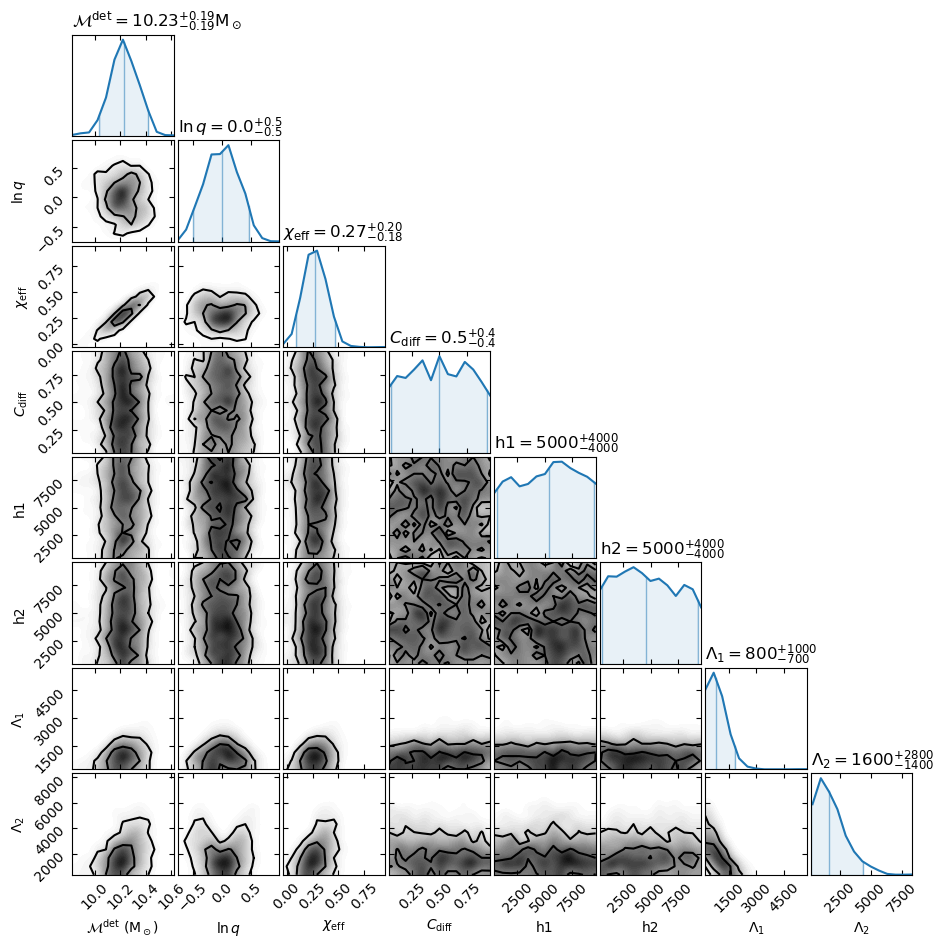

In [24]:
samples = pd.read_feather(rundir_posterior/'samples.feather')
gw_plotting.CornerPlot(samples[post.prior.sampled_params]).plot()

In [26]:
samples.keys()

Index(['mchirp', 'lnq', 'chieff', 'cumchidiff', 'h1', 'h2', 'l1', 'l2', 'm1',
       'm2', 's1z', 's2z', 'f_ref', 'd_luminosity', 'dec', 'lon', 'phi_ref',
       'psi', 'iota', 't_geocenter', 'lnl_marginalized', 'lnl', 'h_h',
       'n_effective', 'n_qmc', 'ra'],
      dtype='object')

In [27]:
samples['hs'] = (samples['m1']**3*samples['h1'] + samples['m2']**3*samples['h2'])/(samples['m1']+samples['m2'])**3
samples['ha'] = (samples['m1']**3*samples['h1'] - samples['m2']**3*samples['h2'])/(samples['m1']+samples['m2'])**3
samples['leff'] = leff(samples['m1'], samples['m2'], samples['l1'], samples['l2'])

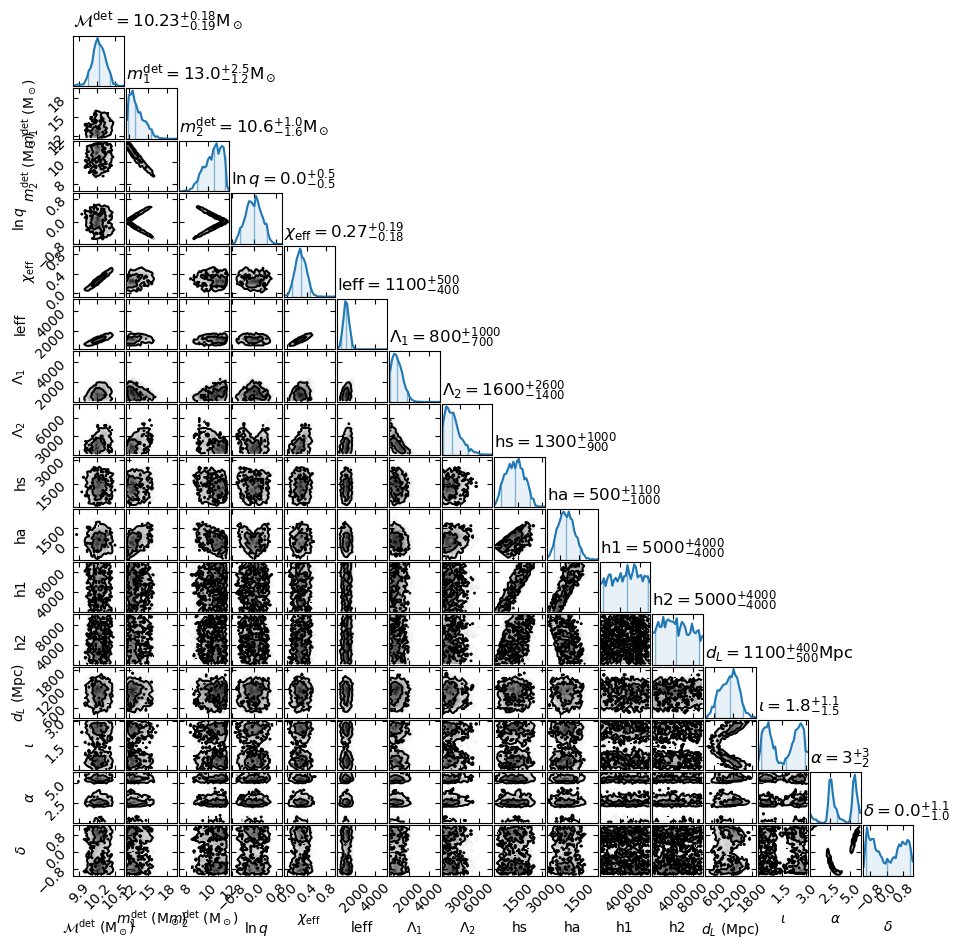

In [28]:
plot_params = ['mchirp', 'm1', 'm2', 'lnq', 'chieff', 'leff', 'l1', 'l2', 'hs', 'ha', 'h1', 'h2', 'd_luminosity', 'iota', 
               'ra', 'dec']
cp = gw_plotting.CornerPlot(samples[plot_params], bins=30)

cp.plot(tightness=.999, max_n_ticks=3)
# cp.scatter_points(par_dic, colors=['C3'])

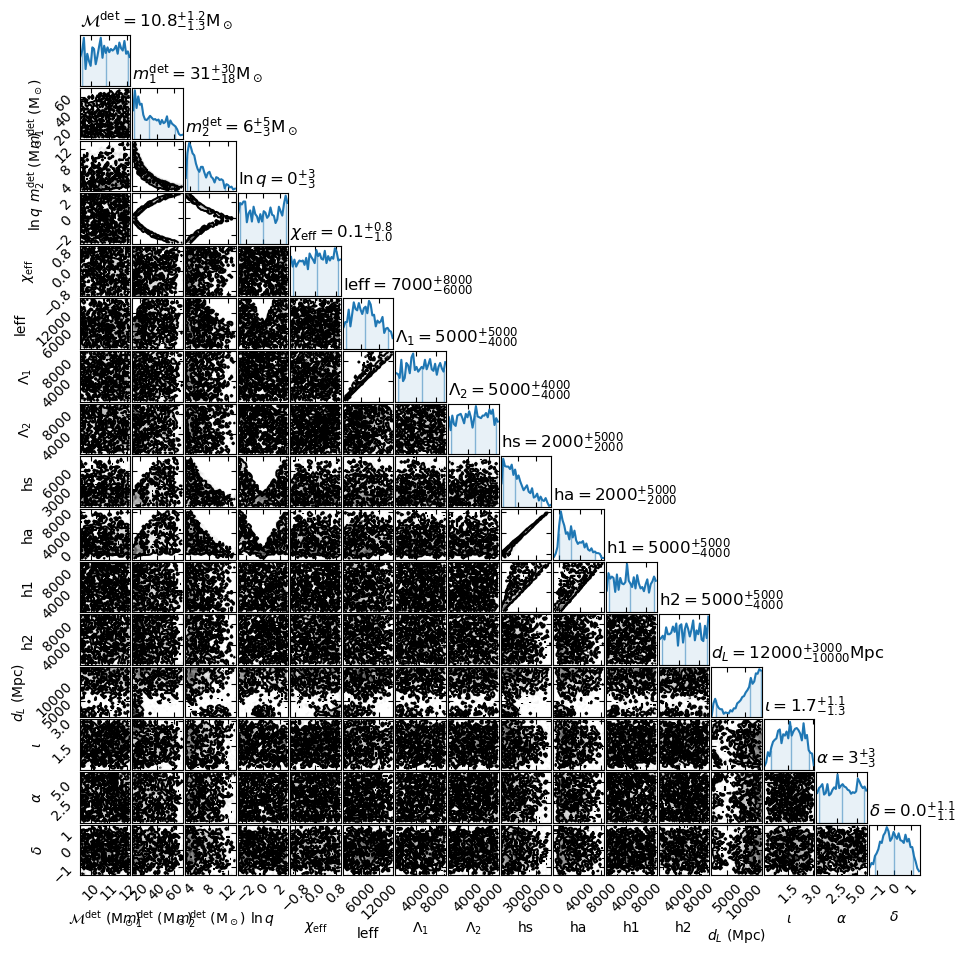

In [18]:
plot_params = ['mchirp', 'm1', 'm2', 'lnq', 'chieff', 'leff', 'l1', 'l2', 'hs', 'ha', 'h1', 'h2', 'd_luminosity', 'iota', 
               'ra', 'dec']
cp = gw_plotting.CornerPlot(samples[plot_params], bins=30)

cp.plot(tightness=.999, max_n_ticks=3)
# cp.scatter_points(par_dic, colors=['C3'])